# Expected Value of Cost function in population setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate $n$D Data

In [2]:
def generate_data_nD(length, n, A):
    
    # Initialize series
    series = np.array(np.zeros((length, n)))
    
    inv_P = np.linalg.inv(P)
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = np.matmul(inv_P, np.matmul(A, np.matmul(P, series[t - 1])) + np.random.multivariate_normal(np.zeros(n), Sigma))
    
    return series

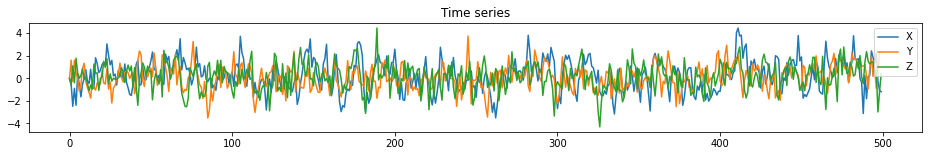

[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]


In [21]:
np.random.seed(seed = 1)

length, n = 500, 3
A, P, Sigma = None, None, None 

if n == 2:
    A = np.array([[0.4, 0.9], [0.1, 0.4]])
    P = np.array([[1.0, 0.0], [0.0, 1.0]])
    Sigma = np.identity(n)
elif n == 3:
    A = np.array([[0.5, 0.0, 0.0], [0.3, 0.4, 0.0], [0.2, 0.3, 0.6]])
    Sigma = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    P = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]])
    # A = np.round(np.random.rand(n, n) / 2, 2)
    
elif n == 4:
    
    P = np.array([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0]])

# Generate nD data
series = generate_data_nD(length, n, A)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

As, Ps = A.copy(), P.copy()

print(A)

# Cost Function
$$C(A, P, A^*, P^*) = \left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2,$$
where we use the following value to predict $X_t$:
$$X_{t,pred} = P^{-1}APX_{t-1}$$
In reality, there is some underlying $P^*$, $A^*$ used to generate $X_{t,val}:$
$$X_{t, val} = P^{*-1}A^*P^*X_{t-1} + \Sigma.$$

This means that the cost function is 
$$C(A, P, A^*, P^*) = \left\lVert P^{*-1}A^*P^*X_{t-1} + \Sigma- P^{-1}APX_{t-1}\right\rVert_2^2,$$

## Distribution of $X$
We assume that $X_1 \sim \mathcal{N}\left(\mathbf{0}, \Sigma\right)$. Then, the distribution of $X_t$, where $t$ can be any integer, will be

$$X_t \sim \mathcal{N}\left(0, \Sigma_X\right),$$

where $$\text{vec}(\Sigma_X) = \left(I_{n^2} - B^* \otimes B^*\right)^{-1} \text{vec}(\Sigma),$$

and $$B^* = P^{*-1} A^* P^*.$$

More specifically, we have

$$\Sigma_X = \left(\text{vec}\left(I_n\right)^T \otimes I_m\right)\left(I_n \otimes \text{vec}(\Sigma_X) \right).$$

In [22]:
def expected_cost(A, P, As = As, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

In [23]:
def expected_cost_2(A, P, As = As, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.tril(np.matmul(P_inv, np.matmul(A, P)))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

We see that the analytic approach and the data sampling approach yield almost identical results, with the data sampling approach converging to the analytic approach when we take an infinite amount of samples.
## Expected cost when using $P^*$ and $A^*$
\begin{align*}\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] &= \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right) \\
&= \text{Tr}\left(\Sigma + \left(B^* - B^*\right)\Sigma_X\left(B^* - B^*\right)^T\right) \\
&= \text{Tr}\left(\Sigma\right).
\end{align*}
Hence, we see that we achieve the minimum for $P^*$ and $A^*$.

In [24]:
def C_n(A = As, P = Ps):
    """
    Given that series has been generated according to P*, A*,
    This function returns the cost when using estimates P, A.
    """
    
    cost = 0

    P_inv = np.linalg.inv(P)

    for t in range(1, length):
        val = series[t]
        est = np.matmul(P_inv, np.matmul(A, np.matmul(P, series[t - 1])))
        cost += np.linalg.norm(val - est) ** 2

    return cost / (length - 1)

print("Expected Cost when using P* and A*:", np.trace(Sigma))
print("Expected Cost when using P* and A*:", expected_cost(As, Ps))
print("Cost from data when using P* and A*:", round(C_n(), 3))

Expected Cost when using P* and A*: 3.0
Expected Cost when using P* and A*: 3.0
Cost from data when using P* and A*: 2.973


In [25]:
print("Expected Cost when using P* and A* full rank:", np.trace(Sigma))

import itertools
P_list = np.array(list(itertools.permutations(np.identity(n))))

for i in range(len(P_list)):
    print(np.tril(np.matmul(P_list[i], A)))
    print("Expected Cost when using A:", expected_cost_2(A, np.array(P_list[i])))

Expected Cost when using P* and A* full rank: 3.0
[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
Expected Cost when using A: 3.64827537593985
[[0.5 0.  0. ]
 [0.2 0.3 0. ]
 [0.3 0.4 0. ]]
Expected Cost when using A: 3.657297932330827
[[0.3 0.  0. ]
 [0.5 0.  0. ]
 [0.2 0.3 0.6]]
Expected Cost when using A: 3.669819078947368
[[0.3 0.  0. ]
 [0.2 0.3 0. ]
 [0.5 0.  0. ]]
Expected Cost when using A: 3.209761904761905
[[0.2 0.  0. ]
 [0.5 0.  0. ]
 [0.3 0.4 0. ]]
Expected Cost when using A: 3.71906719924812
[[0.2 0.  0. ]
 [0.3 0.4 0. ]
 [0.5 0.  0. ]]
Expected Cost when using A: 3.3421428571428575


In [26]:
print("Expected Cost when using A:", expected_cost(np.tril(A), Ps))

Expected Cost when using A: 3.0


# Distribution of $\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]$
To derive the expectation of the cost, we first rewrite to
\begin{align*}
    \mathbb{E}\left[\left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2\right] &= \mathbb{E}\left[\sum_{i=1}^n \left(X_{t,val,i} - X_{t,pred,i} \right)^2\right]\\
    &= \text{Tr}\left(\mathbb{V}\left(X_{t,val} - X_{t, pred})\right)\right) \\
\end{align*}
coSo, we see that we need to determine the covariance of $X_{t,val} - X_{t,pred}$, or rather its trace. We derive the variance as follows:

\begin{align*}
\mathbb{V}\left(X_{t,val} - X_{t, pred})\right) &= \mathbb{V}\left(P^{*-1}A^*P^* X_{t-1} + \Sigma - P^{-1}APX_{t-1})\right)\\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t-1}\right)&\tag{Due to independence of $\Sigma$} \\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t}\right)&\tag{$X_t$, $X_{t-1}$ have same distribution} \\
&= \Sigma + \left(B^* - B\right)\mathbb{V}\left(X_{t}\right)\left(B^* - B\right)^T &\tag{Constant out of covariance}\\
&= \Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T, \tag{Fill in $\Sigma_X$}\\
\end{align*}
where $$B^* = P^{*-1} A^* P^*,\qquad B = P^{-1} A P.$$
Hence, 
$$\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] = \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right).$$

Furthermore, we see that the expected cost is a function of our data-generating $P^*$, $A^*$, and of our estimates $P$, $A$.

### Derivative of the population cost setting w.r.t. $A$
\begin{align*}\frac{\partial \mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]}{\partial A_{ij}} &= \frac{\partial \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial A_{ij}} \tag{Fill in derived expected cost}\\
&= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial A_{ij}} + \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial A_{ij}} \tag{Separate sum of derivatives} \\ &= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial A_{ij}} + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial A_{ij}}\right) \tag{Interchange trace and derivative} \\ &= 0 + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial A_{ij}}\right) \tag{Derivative of $\Sigma$ is 0}\\ &= 2 \text{Tr}\left(\Sigma_X(B^* - B)^T \frac{\partial B^* - B}{\partial A_{ij}}\right) \tag{Use chain rule}\\ &= -2 \text{Tr}\left(\Sigma_X(B^* - B)^T P^{-1} J^{ij} P\right) \tag{Work out last derivative}
,\end{align*} where $$J^{ij}_{kl} = \begin{cases} 1 & k = i, l = j \\ 0 & \text{otherwise.}\end{cases}$$

In [27]:
def B_grad_a(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    return -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), np.matmul(P_inv, np.matmul(J, P)))))

In [35]:
print(B_grad_a(A - 1, P, 0, 0))

-3.6547619047619047


### Derivative of the population cost setting w.r.t. $P$
\begin{align*}\frac{\partial \mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]}{\partial P_{ij}} &= \frac{\partial \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial P_{ij}} \tag{Fill in derived expected cost}\\
&= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial P_{ij}} + \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial P_{ij}} \tag{Separate sum of derivatives} \\ &= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial P_{ij}} + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial P_{ij}}\right) \tag{Interchange trace and derivative} \\ &= 0 + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial P_{ij}}\right) \tag{Derivative of $\Sigma$ is 0}\\ &= 2\text{Tr}\left(\Sigma_X(B^* - B)^T \frac{\partial B^* - B}{\partial P_{ij}}\right) \tag{Use chain rule}\\ &= -2 \text{Tr}\left(\Sigma_X(B^* - B)^T \left(- P^{-1} J^{ij} P^{-1} AP + P^{-1}AJ^{ij}\right)\right) \tag{Work out last derivative}
,\end{align*} where $$J^{ij}_{kl} = \begin{cases} 1 & k = i, l = j \\ 0 & \text{otherwise.}\end{cases}$$

In [10]:
def B_grad_p(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    B_grad = np.matmul(P_inv, np.matmul(A, J))
    B_grad -= np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(A, P))))
    
    return -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), B_grad)))

## Verifications

### Gradient of A for $A = A^*$, $P = P^*$

1 1, ...,  [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
1 2, ...,  [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
1 3, ...,  [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
2 1, ...,  [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
2 2, ...,  [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
2 3, ...,  [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
3 1, ...,  [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
3 2, ...,  [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
3 3, ...,  [[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]


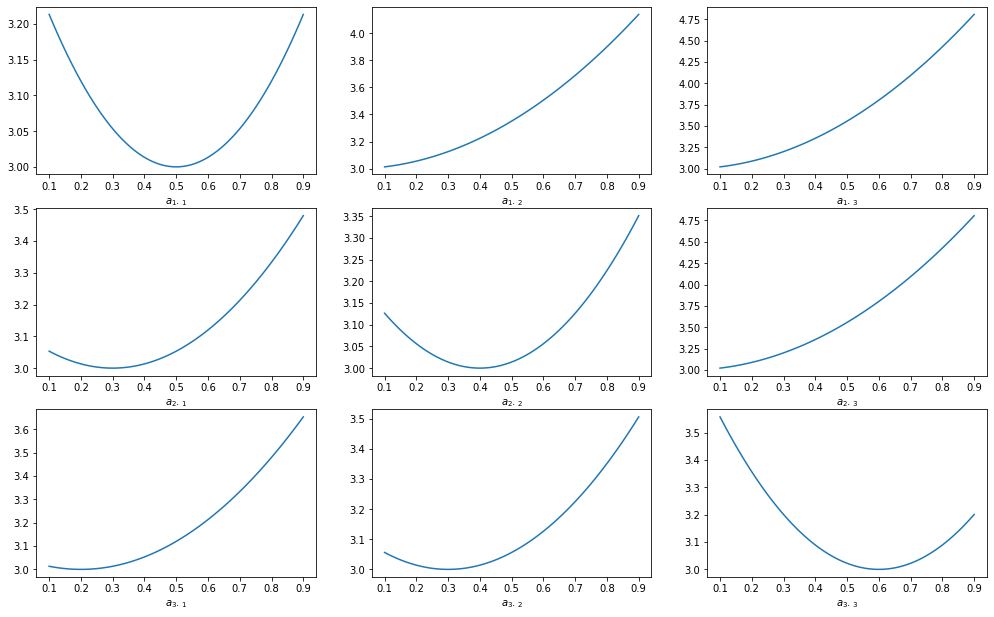

In [36]:
def verify_gradient_a(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    a_list = np.linspace(0.1, 0.9, 99)
    results = [[], []]
    
    a_temp = A[i - 1][j - 1]
    
    for a in a_list:
#         print(a)
        A[i - 1][j - 1] = a
        results[0].append(expected_cost(A, P, As, Ps))
#         print(results[0])
        
    A[i - 1][j - 1] = a_temp
    print(A)
    plt.xlabel(f"$a_{i}._{j}$")
    
    # print(f"Setting P[{i}][{j}] to optimum {0.01 + 0.98 * np.argmin(results[0]) / 100}")
    # A[i - 1][j - 1] = 0.01 + 0.98 * np.argmin(results[0]) / 100

    plt.plot(a_list, results[0])        

# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As.copy(), Ps.copy()

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_a(k // n + 1, k % n + 1, P = P, A = A)

In [ ]:
def sinkhorn_balance(P):
    for _ in range(10):
        # normalize rows
        r_sum = P.sum(axis=1)
        P = P / r_sum[:, np.newaxis]
        
        
        c_sum = P.sum(axis = 0)
        P = P / c_sum
    return P

print(sinkhorn_balance(np.array([[0.1, 0.2], [0.2, 0.3]])))

In [39]:
def verify_gradient_a(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    a_list = np.linspace(-2, 2, 100)
    results = [[], []]
    
    a_temp = A[i - 1][j - 1]
    
    for a in a_list:
        A[i - 1][j - 1] = a
        results[0].append(expected_cost(A, P, As, Ps))
        results[1].append(B_grad_a(A, P, i - 1, j - 1))
        
    A[i - 1][j - 1] = a_temp

    plt.xlabel(f"$a_{i}._{j}$")
    
#     print(f"Setting A[{i}][{j}] to optimum {-2 + 4 * np.argmin(results[0]) / 5000}")
#     A[i - 1][j - 1] = -2 + 4 * np.argmin(results[0]) / 5000
    
    if i == 1 and j == 1:
        plt.plot(a_list, results[0], label = r"$C(a_{ij})$")
        plt.plot(a_list, results[1], label = r"$\frac{\partial C(a_{ij})}{\partial a_{ij}}$")
        plt.plot([-2, 2], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$", color = 'blue') 
    else:
        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([-2, 2], [0, 0], linestyle = '--')
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', color = 'blue')
        

1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

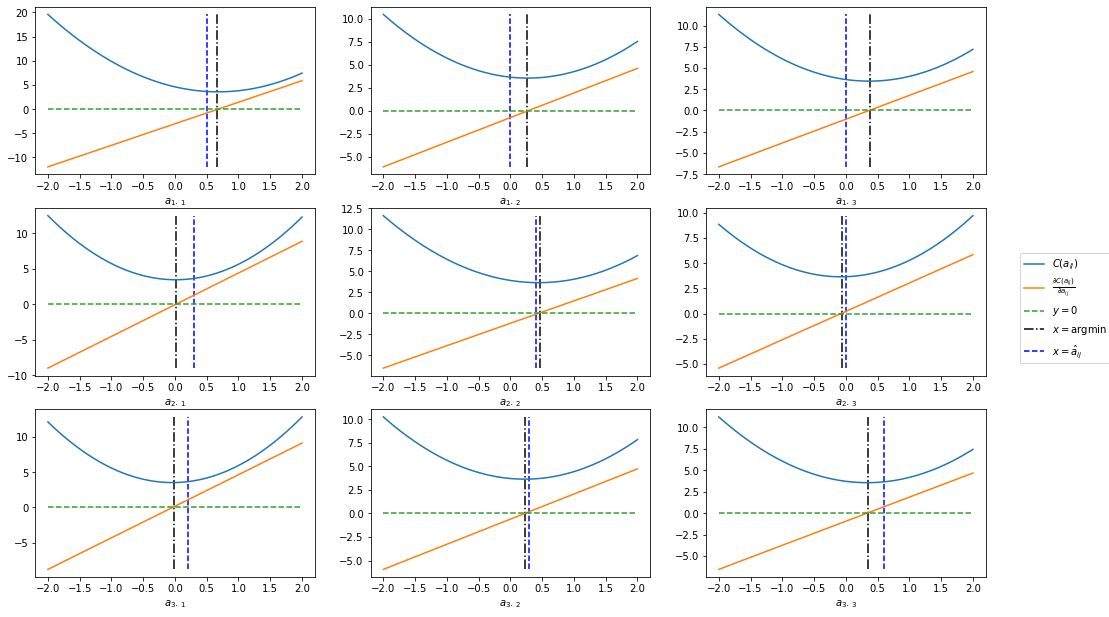

In [40]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As.copy(), np.identity(n)

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_a(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

In [ ]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = np.random.rand(n, n), np.identity(n)

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_a(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

### Verify gradient of $P$ for $A = A^*$ and $P = P^*$

In [ ]:
def verify_gradient_p(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    p_list = np.linspace(-0.01, 0.99, 100)
    results = [[], []]
    
    p_temp = P[i - 1][j - 1]
    
    for p in p_list:
        P[i - 1][j - 1] = p
        results[0].append(expected_cost(A, P, As, Ps))
        results[1].append(B_grad_p(A, P, i - 1, j - 1))
        
    P[i - 1][j - 1] = p_temp

    for a in range(2):
        for b in range(100):
            if abs(results[a][b] ) > 8.000:
                results[a][b] = np.sign(results[a][b]) * 8.000
            
    plt.xlabel(f"$p_{i}._{j}$")
    
    # plt.ylim(-4.500,4.500)
    if i == 1 and j == 1:
        plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
        plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
        plt.plot([0, 1], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(p_{ij})$", color = 'black')
        plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{p}_{ij}$")
    else:
        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        plt.plot([0, 1], [0, 0], linestyle = '--')
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

In [ ]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As.copy(), Ps.copy()

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_p(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

In [ ]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As.copy(), np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]])

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_p(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

In [ ]:
def top_sort(A):
    """Input, WAM A"""
    # We do not take self-loops into account
    WAM = A.copy()
    np.fill_diagonal(WAM, 0)
    
    top_order = np.array([])
    
    # iterative remove the row with no zeros
    while len(top_order) != WAM.shape[0]:
        print(WAM)
        # find row with zeros
        for i in range(WAM.shape[0]):
            print(top_order)
            if np.all((WAM[i] == 0)) and i not in top_order:
                top_order = np.append(top_order, i)
                
                # remove all entries in the row and column
                WAM[i] = 0
                WAM[:,i] = 0  
                
        
    return top_order

print(A)
perm = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
A2 = A
print(A2)
top_sort(A)

In [ ]:
print("Expected Cost when using P* and A* full rank:", np.trace(Sigma))

n = 2
import itertools
np.random.seed(3)
A = np.tril(np.round(np.random.rand(n, n) / 2, 2))
print(A)
P_list = np.array(list(itertools.permutations(np.identity(n))))

for i in range(len(P_list)):
    P2 = np.array(P_list[i])
    P_inv = np.linalg.inv(P2)
    print((np.matmul(A, P2)))
    # print("Expected Cost when using A:", expected_cost_2(A, np.array(P_list[i])))

## Try to find $A^*$ and $P^*$ iteratively

In [ ]:
def set_gradient_a(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    a_list = np.linspace(-2, 2, 200)
    results = [[], []]
    
    a_temp = A[i - 1][j - 1]
    
    for a in a_list:
        A[i - 1][j - 1] = a
        results[0].append(expected_cost(A, P, As, Ps))
        results[1].append(B_grad_a(A, P, i - 1, j - 1))
        
    A[i - 1][j - 1] = a_temp
    
    print(f"Setting A[{i}][{j}] to optimum {-2 + 4 * np.argmin(results[0]) / 200}")
    if j <= i:
        A[i - 1][j - 1] = -2 + 4 * np.argmin(results[0]) / 200
    else:
        A[i - 1][j - 1] = 0

In [ ]:
def set_gradient_p(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    p_list = np.linspace(0.01, 0.99, 100)
    results = [[], []]
    
    p_temp = P[i - 1][j - 1]
    
    for p in p_list:
        P[i - 1][j - 1] = p
        results[0].append(expected_cost(A, P, As, Ps))
        results[1].append(B_grad_p(A, P, i - 1, j - 1))
        
    P[i - 1][j - 1] = p_temp
    
    print(f"Setting P[{i}][{j}] to optimum {0.01 + 0.98 * np.argmin(results[0]) / 100}")
    P[i - 1][j - 1] = 0.01 + 0.98 * np.argmin(results[0]) / 100

In [ ]:
# start with random initializations (e.g. A zero, P close to J / n)
A = np.zeros((n, n))
P = np.ones((n, n)) / (1.1 * n) + np.identity(n) / (11)

# iterativel set A[i][j], P[i][j] to argmin C
for k in range(n ** 2):
    set_gradient_a(k // n + 1, k% n + 1, P, A)
for k in range(n ** 2):
    set_gradient_p(k // n + 1, k% n + 1, P, A)

# sinkhorn balance P to make sure P is DS
print(expected_cost(A, P))

In [ ]:
A, P = As.copy(), Ps.copy()

for _ in range(10):
    # iterativel set A[i][j], P[i][j] to argmin C
    for k in range(n ** 2):
        set_gradient_a(k // n + 1, k % n + 1, P, A)
    for k in range(n ** 2):
        set_gradient_p(k // n + 1, k % n + 1, P, A)
        P = sinkhorn_balance(P)

# sinkhorn balance P to make sure P is DS
print(P)
print(A)
print(expected_cost(A, P))
print(Ps)
print(As)

In [ ]:
aparms = int(n * (n + 1) / 2)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def inv_sigmoid(x):
    return np.log(x/(1-x))

def expected_cost_opt(variables):
    # create A
    A = np.zeros((n, n))
    A[np.tril_indices(n)] = variables[:aparms]
    
    # create P
    P = np.array(sigmoid(variables[aparms:])).reshape(n, n)
    
    ## compute expected cost
    # compute inverses
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    # compute B
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    # compute covariance of X
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    # compute covariance of X_{val} - X_{pred}
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    # return cost
    return np.trace(covariance_matrix)

# set dimension
n = 3

# set A
A = np.tril((np.random.rand(n, n)))

# set P
P = np.array([[100, -100, -100], [-100, 100, -100], [-100, -100, 100]])

# define variables
variables = np.append(A[np.tril_indices(n)], P.flatten())

# compute expected cost
expected_cost_opt(variables)

In [ ]:
def eq_cons_ij(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[0]
    return sum(P) - 1

def eq_cons_2(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[1]
    return sum(P) - 1

def eq_cons_3(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[2]
    return sum(P) - 1

def eq_cons_4(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[:, 0]
    return sum(P) - 1

def eq_cons_5(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[:, 1]
    return sum(P) - 1

def eq_cons_6(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[:, 2]
    return sum(P) - 1

cons = [{'type': 'eq', 'fun': eq_cons_1}, {'type': 'eq', 'fun': eq_cons_2}, {'type': 'eq', 'fun': eq_cons_3},
        {'type': 'eq', 'fun': eq_cons_4}, {'type': 'eq', 'fun': eq_cons_5}, {'type': 'eq', 'fun': eq_cons_6}]

In [ ]:
from scipy import optimize
x0 = np.random.rand(aparms + n ** 2)
# x0[aparms:] = np.identity(n).flatten()

results = optimize.minimize(expected_cost_opt, x0, constraints = cons)
attempts = 0
broken_attempts = 0
while results.fun > 3.05 or results.fun < 0:
    attempts += 1
    print(results.fun)
    x0 = np.random.rand(aparms + n ** 2)
    try:
        results = optimize.minimize(expected_cost_opt, x0, constraints = cons)
    except:
        broken_attempts += 1
        print("Error")

print(x0)
print(results.fun)
A_pred = np.zeros((n, n))
A_pred[np.tril_indices(n)] = results.x[:aparms]
P_pred = results.x[aparms:]

print("Attempts:", attempts)
print("Errored attempts:", broken_attempts)

print(np.round(A_pred, 2))
print(np.round(sigmoid(P_pred).reshape((n, n)), 2))

In [ ]:
variables_2 = results.x
results_2 = optimize.minimize(expected_cost_opt, variables_2, constraints = cons)
print(results_2)